<a href="https://colab.research.google.com/github/Jiya-Parmar/ResNet-EuroSAT-Benchmark/blob/main/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline

In [9]:
batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0/255

import os
from google.colab import drive

zip_path = zip_path = '/content/EuroSAT.zip'
dataset_dir = '/content/EuroSAT_unzipped'
dataset_url = os.path.join(dataset_dir, '2750')

drive.mount('/content/drive')
print(f"Zip file path set to: {zip_path}")
print(f"Target unzipping directory: {dataset_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zip file path set to: /content/EuroSAT.zip
Target unzipping directory: /content/EuroSAT_unzipped


In [10]:
import os
os.makedirs(dataset_dir, exist_ok=True)

!unzip -q {zip_path} -d {dataset_dir}

print("\n--- Directory Check ---")
try:
    print(f"Contents of unzipped directory: {os.listdir(dataset_dir)}")
except FileNotFoundError:
    print("Unzipping failed or target directory not created.")


--- Directory Check ---
Contents of unzipped directory: ['2750']


In [11]:

import tensorflow as tf
dataset_dir1 = '/content/EuroSAT_unzipped/2750'

# --- 1. Load Training Dataset ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir1,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# --- 2. Load Validation Dataset ---
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir1,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


class_names = train_ds.class_names

# --- 4. Apply Rescaling ---
normalization_layer = tf.keras.layers.Rescaling(rescale)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.05),
  tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.RandomContrast(factor=0.1),
  normalization_layer
])




# --- 5. Optimization ---
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds, apply_augmentation=False):
    if apply_augmentation:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir1, validation_split=validation_split, subset="training", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size
).map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir1, validation_split=validation_split, subset="validation", seed=123,
    image_size=(img_height, img_width), batch_size=batch_size
).map(lambda x, y: (normalization_layer(x), y))

# Apply final optimizations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and prepared with data augmentation.")

print("Datasets loaded and prepared using the tf.data API.")
# --- 6. Use the stored variable for printing ---
print(f"Total classes found: {len(class_names)}")
print(f"Class names: {class_names}")

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Datasets loaded and prepared with data augmentation.
Datasets loaded and prepared using the tf.data API.
Total classes found: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


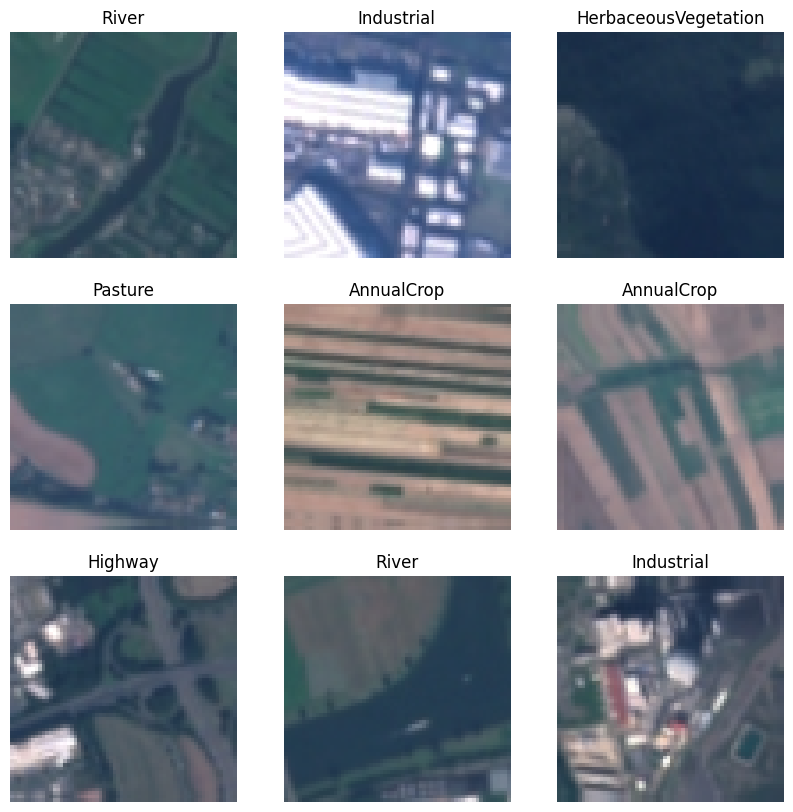

In [12]:
plt.figure(figsize=(10, 10))


for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        if images[i].numpy().max() <= 1.0:
            display_image = (images[i].numpy() * 255).astype("uint8")
        else:
            display_image = images[i].numpy().astype("uint8")

        plt.imshow(display_image)

        plt.title(class_names[labels[i].numpy()])

        plt.axis("off")

In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
L2_REG = 1e-4
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters

    X_shortcut = X
    cache = []

    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid',
               kernel_initializer = initializer(seed=0),
               kernel_regularizer=l2(L2_REG)
              )(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same',
               kernel_initializer = initializer(seed=0),
               kernel_regularizer=l2(L2_REG)
              )(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid',
               kernel_initializer = initializer(seed=0),
               kernel_regularizer=l2(L2_REG)
              )(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X

In [17]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):

    F1, F2, F3 = filters

    X_shortcut = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0), kernel_regularizer=l2(L2_REG))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0), kernel_regularizer=l2(L2_REG))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0), kernel_regularizer=l2(L2_REG))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0), kernel_regularizer=l2(L2_REG))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [18]:
from tensorflow.keras.layers import Dropout
def ResNet50(input_shape = (64, 64, 3), classes = 10):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=l2(L2_REG))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    X = Dropout(0.5)(X)

    X = Flatten()(X)
    X = Dense(256, activation='relu', kernel_regularizer=l2(L2_REG), kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.5)(X)

    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0),
              kernel_regularizer=l2(L2_REG))(X)


    model = Model(inputs = X_input, outputs = X)

    return model

model = ResNet50(input_shape=(64,64,3), classes=len(class_names)) # Use len(class_names) for robustness

In [19]:
model = ResNet50(input_shape=(64,64,3), classes=10)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 70, 70, 3) │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 32,    │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 15, 15,    │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 15, 15,    │      4,160 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 15, 15,    │     36,928 │ activation_56[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 15, 15,    │     16,640 │ activation_57[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 15, 15,    │     16,640 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │      1,024 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 5e-4

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 109s 72ms/step - accuracy: 0.6665 - loss: 1.7204 - val_accuracy: 0.5574 - val_loss: 1.8723 - learning_rate: 5.0000e-04
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.7405 - loss: 1.2597 - val_accuracy: 0.3322 - val_loss: 63.5361 - learning_rate: 5.0000e-04
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.7676 - loss: 1.1199 - val_accuracy: 0.5341 - val_loss: 8.3913 - learning_rate: 5.0000e-04
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.7935 - loss: 0.9946 - val_accuracy: 0.5787 - val_loss: 1.7687 - learning_rate: 5.0000e-04
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.8316 - loss: 0.8752 - val_accuracy: 0.6219 - val_loss: 1.5426 - learning_rate: 5.0000e-04
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/step - accuracy: 0.8407 - loss: 0.8345 - val_accuracy: 0.7444 - val_loss: 1.0821 - learning_rate: 5.0000e-04
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 39s 58ms/s

In [22]:
 model.save(r'model/model_100_epoch.h5')


In [23]:
from tensorflow.keras.models import load_model
model = load_model(r"model/model_100_epoch.h5")

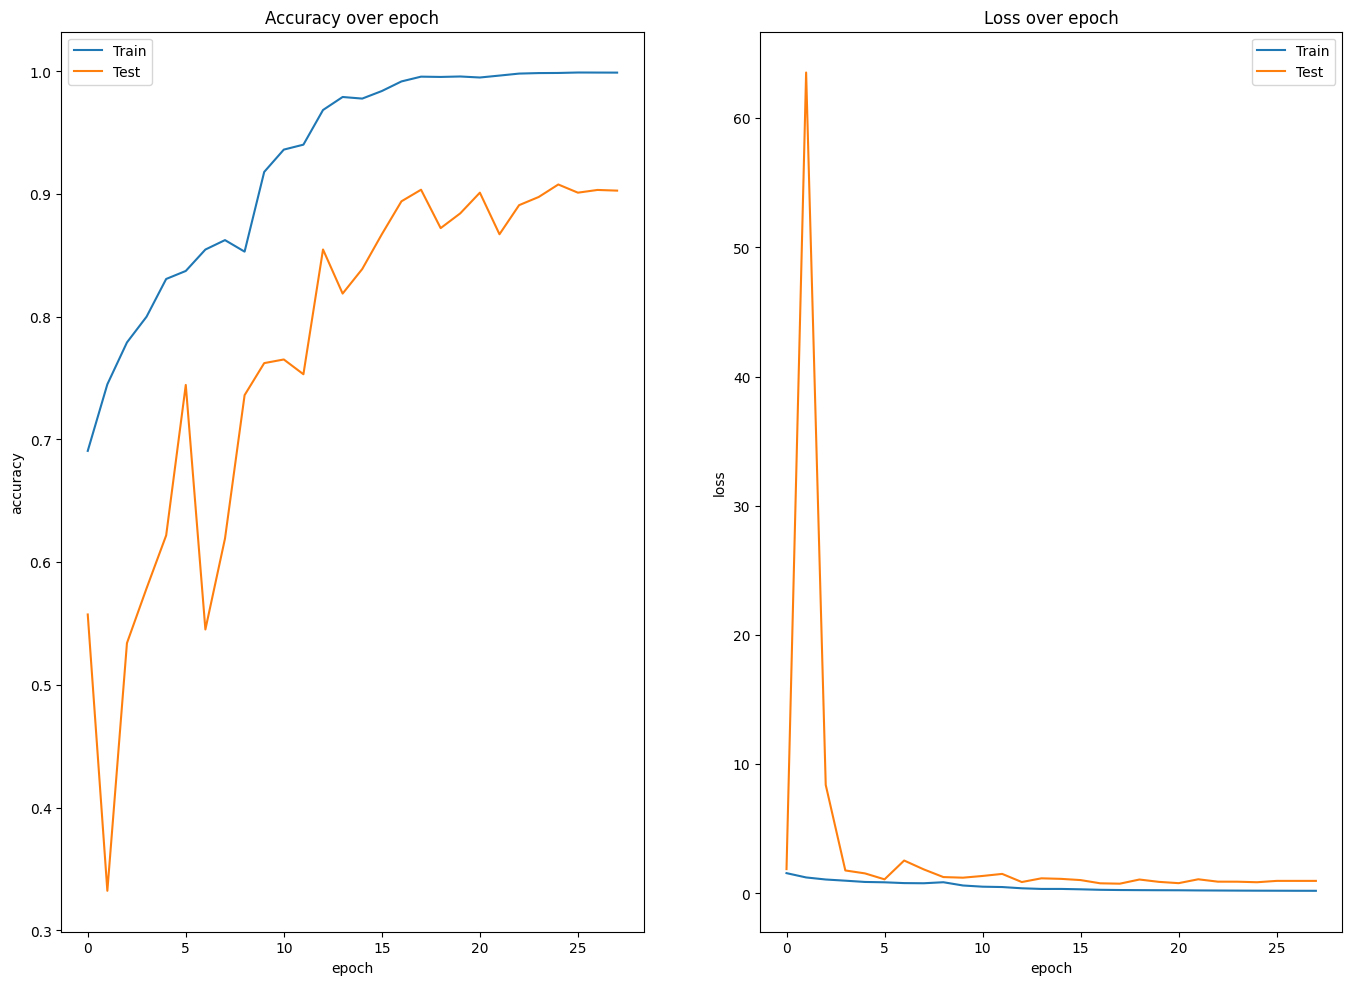

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [25]:
y_pred = []
y_true = []
for i, (image_batch, label_batch) in enumerate(val_ds):
    y_true.append(label_batch)

    preds = model.predict(image_batch, verbose=0)

    y_pred.append(np.argmax(preds, axis = 1))

    if i == 300:
        break

correct_labels = tf.concat([item for item in y_true], axis = 0)

predicted_labels = tf.concat([item for item in y_pred], axis = 0)

correct_labels_np = correct_labels.numpy()
predicted_labels_np = predicted_labels.numpy()

print(f"Total validation samples processed: {len(correct_labels_np)}")

Total validation samples processed: 5400


In [26]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[470,   4,   8,   7,   0,  17,  31,   0,  19,   3],
       [  0, 606,   5,   0,   0,   0,   0,   0,   2,   1],
       [  1,   9, 536,   2,   5,   0,  19,  16,   1,   0],
       [  0,   1,   9, 420,  20,   3,  10,  16,  19,   1],
       [  0,   0,   1,   1, 447,   0,   0,  38,   1,   0],
       [  1,  20,  16,   1,   0, 335,  15,   1,   3,   1],
       [  3,   0,  69,   4,   9,   1, 428,  11,   4,   0],
       [  0,   0,   1,   1,   3,   0,   0, 632,   0,   0],
       [  7,   4,  12,  24,   4,  10,   4,   1, 425,   0],
       [  1,  14,   3,   0,   0,   1,   0,   0,   2, 580]])

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

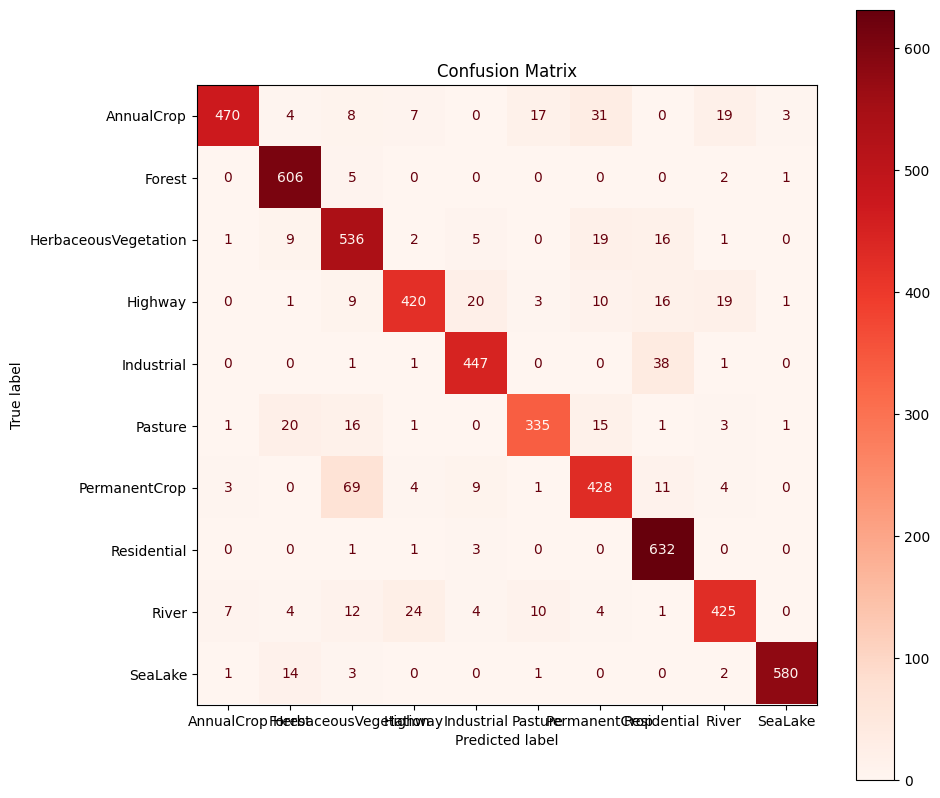

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

# 2. Plot the matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap='Reds', ax=plt.gca())

# 3. Add titles and show
plt.title('Confusion Matrix')
plt.show()